## 017 Pilot active/passive delta models v3 - changes in craving (single subject)

Date: 01.Aug.2022

### Purpose

Create a model classes where changes in craving (delta) is predicted rather than absolute craving.

### Outline of Plan

1. Copy over RetroPrototype, TempRetroPrototype from NB#015
2. Copy over all child classes from NB#015
3. Modify models to predict $\Delta craving$ rather than $|craving|$
4. Run subjects 7 and 15 - other block, visualize parameter estimates and model comparison

### What we did in this notebook

1. RetroPrototype and TempRetroPrototype classes modified to calculate delta cravings in addition to normed craving and standard cravings.
2. Separate child classes do not need to be defined for delta craving models. The only change that needs to be made is to call a different crav_variant prop when fitting the model.
3. Model comparison and visualization of predicted cravings performed for standard and delta models.

### Overall conclusions

1. Delta models overall, by spot check of subjects 7, 15, 16, do not seem to perform as well as normed craving ratings.
2. This simplifies the analysis pipeline quite a bit. See NB#002 in online/prolific-food-craving/derivatives/joint/nb+s/exploration/ for next steps.
3. Essentially, the set of models to explore have been decided. 28 total + heuristic + biased as null models, total of 30.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## (Normed) Retrospective prototype class

### RetroPrototype
Assumptions:
1. Both non-normed and normed cravings are calculated and stored
2. Craving inds are calculated
3. Craving means and st. dev. are calculated
4. Beta is the first variable specified, only one beta, and is a required argument
5. Non-sequences in aesara loop DO NOT include beta
6. Sigma in craving_lik equals 1
7. Normed craving retrieved in fit function
8. MAJOR DIFF: 7 rows in aesara loop, Q[left], Q[right], pred_craving, Q[t-1], Q[t-2], PE[t-1], PE[t-2]

In [44]:
class RetroPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.delta_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.norm_delta_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

                delta = []
                for i, c in enumerate(cravings):
                    if i==0:
                        delta.append(0)
                    else:
                        delta.append(c - cravings[i-1])
                self.delta_cravings[b, pid_num, :] = np.array(delta)
                self.norm_delta_cravings[b, pid_num, :] = stats.zscore(self.delta_cravings[b, pid_num, :])
                

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        t_pred_craving = loopvals[:, 2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, crav_variant):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if crav_variant=='norm':
            crav = self.norm_cravings[b, pid_num, :]
        elif crav_variant=='standard':
            crav = self.cravings[b, pid_num, :]
        elif crav_variant=='delta':
            crav = self.delta_cravings[b, pid_num, :]
        elif crav_variant=='norm_delta':
            crav = self.norm_delta_cravings[b, pid_num, :]
        # cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        # craving_inds = np.squeeze(np.argwhere(cravings>-1))
        # mask = np.ones(len(craving_inds), dtype=bool)
        # mask[12] = False
        # craving_inds = craving_inds[mask]
        # cravings = cravings[craving_inds]
        # norm_cravings = stats.zscore(cravings)
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block, crav_variant):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, crav_variant)
        with pm.Model() as model:
            priors = self._define_priors()
            craving_sig = pm.Exponential('craving_sig', 2)
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[self.craving_inds-1], sigma=craving_sig, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

### TempRetroPrototype
Assumptions:
1. Beta is multiplied by invlogit of predicted craving ratings (modulated by craving ratings)

In [45]:
class TempRetroPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.delta_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.norm_delta_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

                delta = []
                for i, c in enumerate(cravings):
                    if i==0:
                        delta.append(0)
                    else:
                        delta.append(c - cravings[i-1])
                self.delta_cravings[b, pid_num, :] = np.array(delta)
                self.norm_delta_cravings[b, pid_num, :] = stats.zscore(self.delta_cravings[b, pid_num, :])

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        t_pred_craving = loopvals[:, 2]

        # Apply the sotfmax transformation
        mod = at.repeat(at.as_tensor_variable(
            [beta*pm.math.invlogit(t_pred_craving[:-1])]), 
            repeats=2, axis=0
        )
        t_Qs = at.math.mul(t_Qs[:-1], mod.T)
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, crav_variant):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if crav_variant=='norm':
            crav = self.norm_cravings[b, pid_num, :]
        elif crav_variant=='standard':
            crav = self.cravings[b, pid_num, :]
        elif crav_variant=='delta':
            crav = self.delta_cravings[b, pid_num, :]
        elif crav_variant=='norm_delta':
            crav = self.norm_delta_cravings[b, pid_num, :]
        # cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        # craving_inds = np.squeeze(np.argwhere(cravings>-1))
        # mask = np.ones(len(craving_inds), dtype=bool)
        # mask[12] = False
        # craving_inds = craving_inds[mask]
        # cravings = cravings[craving_inds]
        # norm_cravings = stats.zscore(cravings)
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block, crav_variant):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, crav_variant)
        with pm.Model() as model:
            priors = self._define_priors()
            craving_sig = pm.Exponential('craving_sig', 2)
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[self.craving_inds-1], sigma=craving_sig, observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

## Inheritance models

### RW Standard Models

In [46]:
class Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [47]:
class Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six

### RW Active LR Models

In [48]:
class ActiveLR_Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'ActiveLR_Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = (mod-0.5)*2

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha*bias) * pe)

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        # mod = pm.Normal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, mod

In [49]:
class ActiveLR_Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'ActiveLR_Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = (mod-0.5)*2

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha*bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        # mod = pm.Normal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod

### RW Active Temp Models

In [50]:
class ActiveTemp_Retro0step_RW_EVRPE(TempRetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'ActiveTemp_Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [51]:
class ActiveTemp_Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'ActiveTemp_Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six

### RW Active LR+Temp Models

In [52]:
class ActiveLRTemp_Retro0step_RW_EVRPE(TempRetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'ActiveLRTemp_Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = (mod-0.5)*2

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha*bias) * pe)

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        # mod = pm.Normal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, mod

In [53]:
class ActiveLRTemp_Retro2step_Sep_RW_EVRPE(TempRetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'ActiveLRTemp_Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = (mod-0.5)*2

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha*bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        # mod = pm.Normal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod

## Fit models

In [54]:
# passive_0step_model = Retro0step_RW_EVRPE(longform, df_summary, project_dir)
# passive_2step_model = Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
active_lr_0step_model = ActiveLR_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
active_lr_2step_model = ActiveLR_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
# active_temp_0step_model = ActiveTemp_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
# active_temp_2step_model = ActiveTemp_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
# active_lrtemp_0step_model = ActiveLRTemp_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
# active_lrtemp_2step_model = ActiveLRTemp_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)

# passive_0step_model_delta = Retro0step_RW_EVRPE(longform, df_summary, project_dir)
# passive_2step_model_delta = Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
active_lr_0step_model_delta = ActiveLR_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
active_lr_2step_model_delta = ActiveLR_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
# active_temp_0step_model_delta = ActiveTemp_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
# active_temp_2step_model_delta = ActiveTemp_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
# active_lrtemp_0step_model_delta = ActiveLRTemp_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
# active_lrtemp_2step_model_delta = ActiveLRTemp_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)

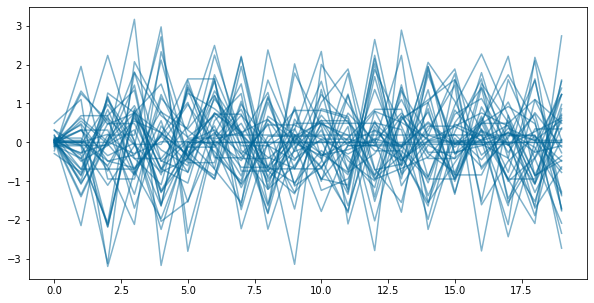

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for ratings in active_lr_0step_model.norm_delta_cravings[0]:
    ax.plot(ratings, '-', color='#006699', alpha=0.5)

In [72]:
active_lr_0step_model_delta.fit(15, 'other', crav_variant='norm_delta')
active_lr_2step_model_delta.fit(15, 'other', crav_variant='norm_delta')
active_lr_0step_model.fit(15, 'other', crav_variant='norm')
active_lr_2step_model.fit(15, 'other', crav_variant='norm')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_mod]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_mod]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_mod]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [untr_mod]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


## Output posterior

In [78]:
pid_num = 15

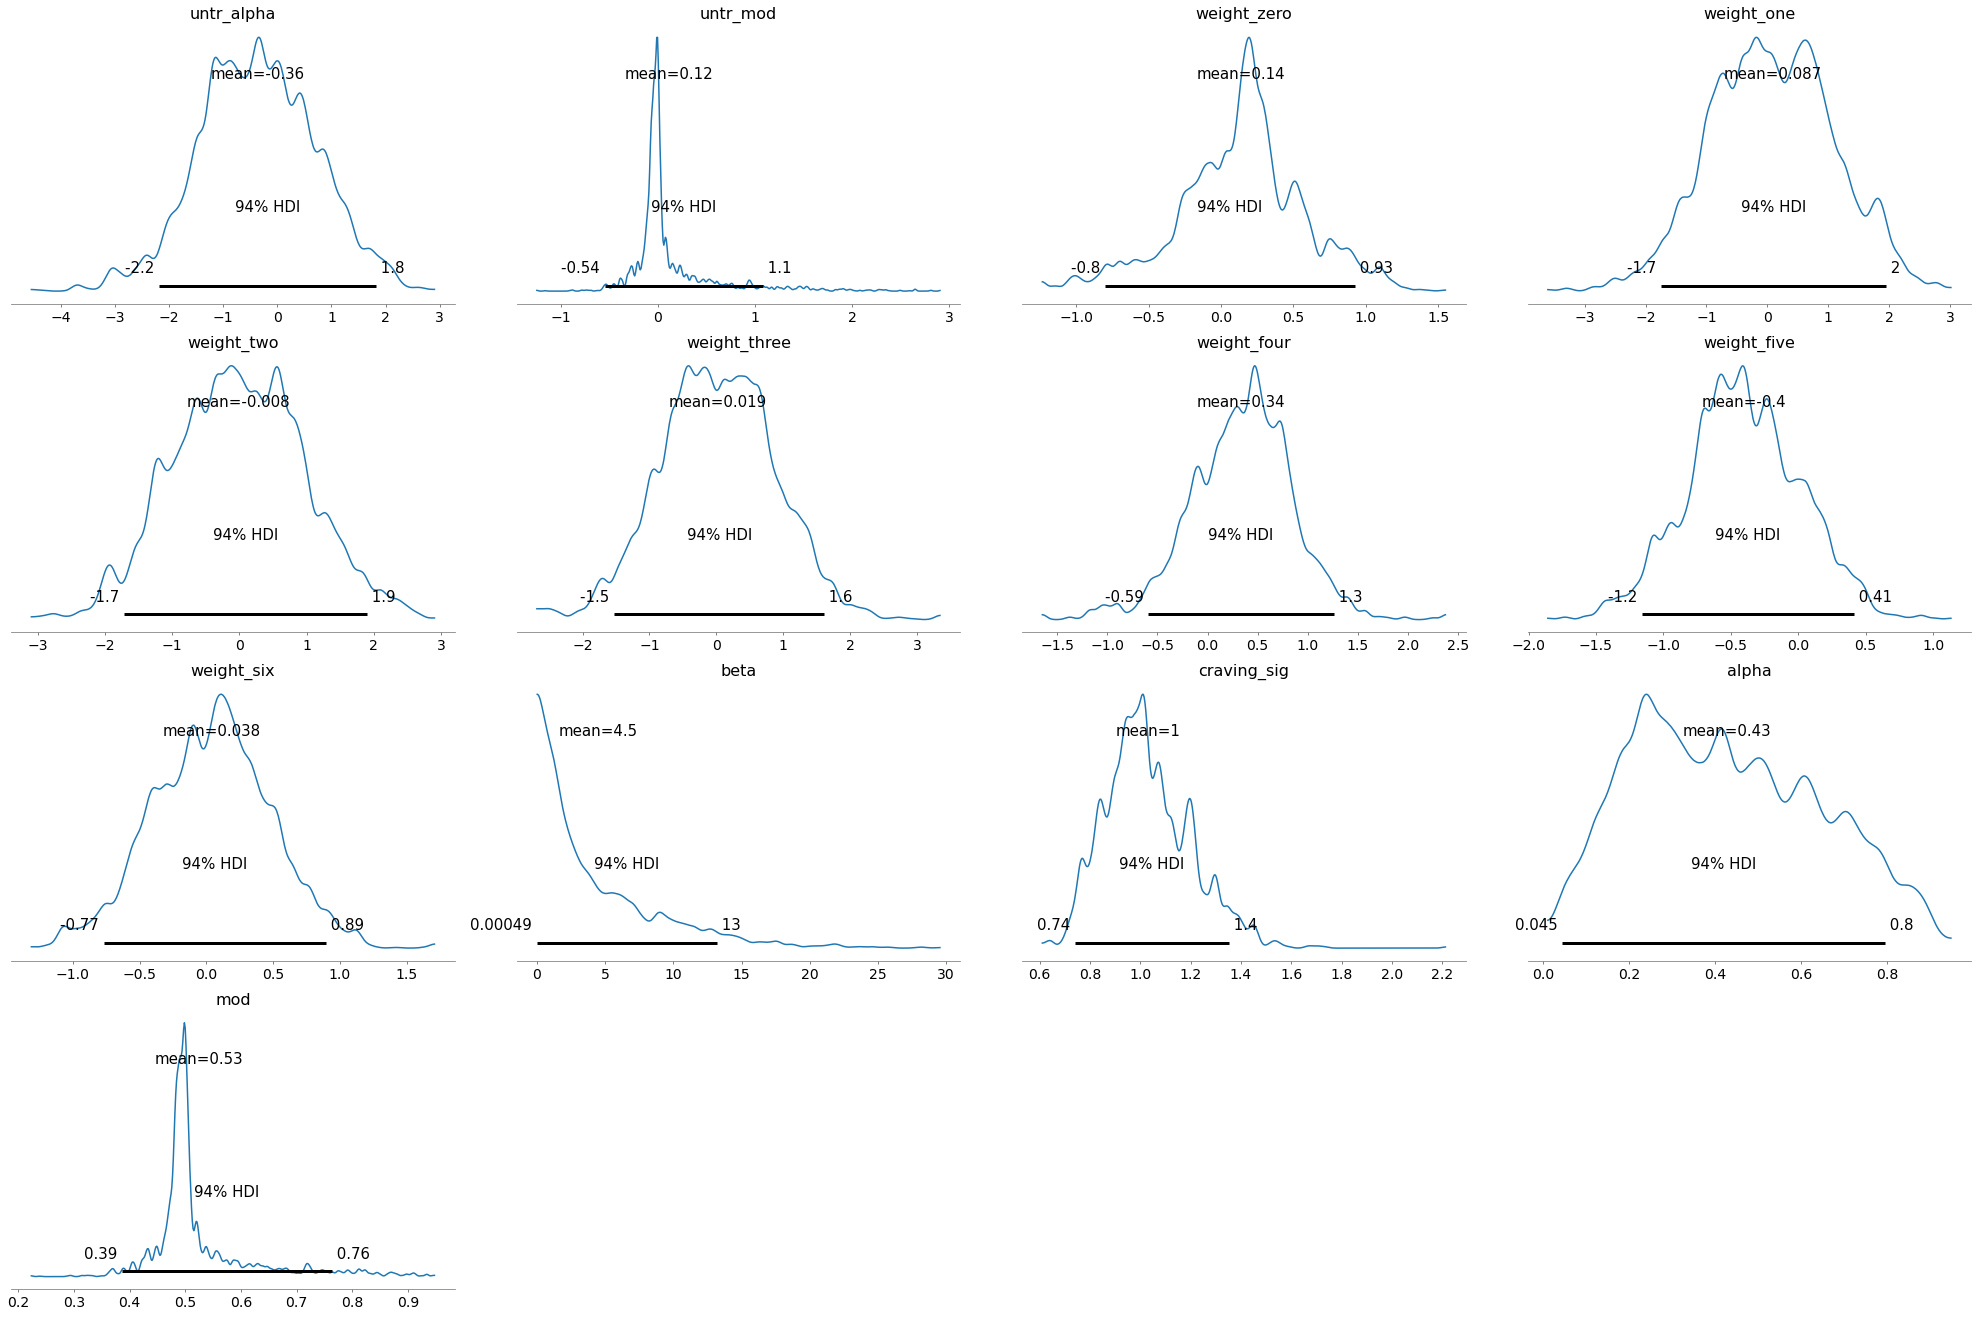

In [79]:
# az.plot_posterior(imm_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(retro2_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(retro2_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(retro2decay_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
az.plot_posterior(active_lr_2step_model_delta.traces['other'][pid_list[pid_num]])
# az.plot_trace(active_temp_2step_model.traces['other'][pid_list[pid_num]])
plt.tight_layout()


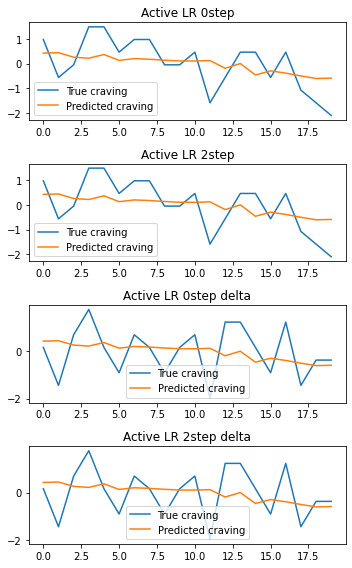

In [80]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5, 8))

for i, model in enumerate([active_lr_0step_model, active_lr_2step_model]):
    sns.lineplot(
        x=np.arange(model.norm_cravings.shape[2]),
        y=active_lr_0step_model.norm_cravings[1, pid_num],
        label='True craving',
        ax=ax[i],
    )
    sns.lineplot(
        x=np.arange(model.norm_cravings.shape[2]),
        y=active_lr_0step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
        label='Predicted craving',
        ax=ax[i],
    )
for i, model in enumerate([active_lr_0step_model_delta, active_lr_2step_model_delta]):
    sns.lineplot(
        x=np.arange(model.norm_delta_cravings.shape[2]),
        y=active_lr_0step_model.norm_delta_cravings[1, pid_num],
        label='True craving',
        ax=ax[i+2],
    )
    sns.lineplot(
        x=np.arange(model.norm_delta_cravings.shape[2]),
        y=active_lr_0step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
        label='Predicted craving',
        ax=ax[i+2],
    )
ax[0].set_title('Active LR 0step')
ax[1].set_title('Active LR 2step')
ax[2].set_title('Active LR 0step delta')
ax[3].set_title('Active LR 2step delta')
# ax[0, 0].set_title('Passive 0step')
# ax[0, 1].set_title('Passive 2step')
# ax[1, 0].set_title('Active LR 0step')
# ax[1, 1].set_title('Active LR 2step')
# ax[2, 0].set_title('Active Temp 0step')
# ax[2, 1].set_title('Active Temp 2step')
# ax[3, 0].set_title('Active LR+Temp 0step')
# ax[3, 1].set_title('Active LR+Temp 2step')
plt.tight_layout()

## Model comparison of EV and EVRPE

In [81]:
model_comp = az.compare({
        # 'Imm_Passive_RW_EVRPE': imm_model.traces['other'][pid_list[7]],
        # 'Passive0': passive_0step_model.traces['other'][pid_list[pid_num]],
        # 'Passive2': passive_2step_model.traces['other'][pid_list[pid_num]],
        'ActiveLR0': active_lr_0step_model.traces['other'][pid_list[pid_num]],
        'ActiveLR2': active_lr_2step_model.traces['other'][pid_list[pid_num]],
        # 'ActiveTemp0': active_temp_0step_model.traces['other'][pid_list[pid_num]],
        # 'ActiveTemp2': active_temp_2step_model.traces['other'][pid_list[pid_num]],
        # 'ActiveLRTemp0': active_lrtemp_0step_model.traces['other'][pid_list[pid_num]],
        # 'ActiveLRTemp2': active_lrtemp_2step_model.traces['other'][pid_list[pid_num]],
        'ActiveLR0_delta': active_lr_0step_model_delta.traces['other'][pid_list[pid_num]],
        'ActiveLR2_delta': active_lr_2step_model_delta.traces['other'][pid_list[pid_num]],
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/jupyter/lib/p

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ActiveLR2,0,-29.876429,6.258116,0.000000,0.620202,2.823146,0.000000,True,log
ActiveLR0,1,-30.020539,4.420187,0.144111,0.000000,2.716579,1.306520,True,log
ActiveLR0_delta,2,-30.611909,2.313056,0.735480,0.379798,2.487588,3.405036,True,log
ActiveLR2_delta,3,-31.722533,4.090477,1.846104,0.000000,2.746642,3.519171,True,log


<AxesSubplot:xlabel='Log'>

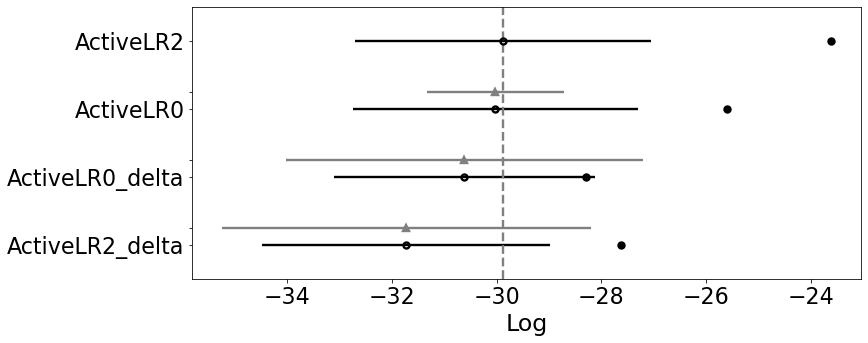

In [82]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))